# 카메라 스티커앱 만들기🐱

얼굴인식 카메라 앱의 원리를 알아보자

## 1. 이미지 준비하기

- 여러 각도와 다양한 얼굴 이미지는 [Unsplash](https://unsplash.com/)에서 가져왔다.
- [고양이 수염 이미지](https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1)는 아이콘 이미지를 사용했다.

In [75]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

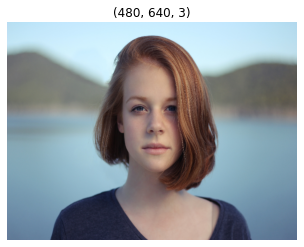

In [76]:
# 얼굴 이미지 불러오기
img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/christopher-campbell-rDEOVtE7vOs-unsplash.jpg'

img_bgr = cv2.imread(img_path, 1) # 이미지 파일 color로 읽기, 1 == cv2.IMREAD_COLOR
img_bgr = cv2.resize(img_bgr, (640, 480)) # 이미지 resize
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # RGB로 색상 변경


plt.imshow(img_rgb)
plt.title(img_rgb.shape)
plt.axis('off')
plt.show()

(-0.5, 511.5, 511.5, -0.5)

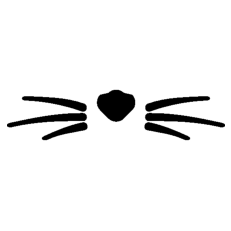

In [77]:
# 스티커 이미지 불러오기
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
# img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker)
plt.axis('off')

## 2. Face Detection

Object detection 기술을 이용해서 얼굴의 위치를 찾는다. 

dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는다.

In [78]:
import dlib

detector_hog = dlib.get_frontal_face_detector() # face detector 불러오기
dlib_rects = detector_hog(img_rgb, 1) # detector_hog(image, upsample_num_times)

print(dlib_rects) # 얼굴영역의 좌표 출력

rectangles[[(242, 139) (428, 325)]]


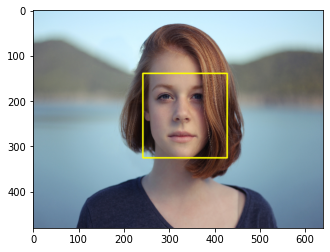

In [79]:
for rect in dlib_rects:
    left = rect.left()
    top = rect.top()
    right = rect.right()
    bottom = rect.bottom()
    width = rect.width()
    height = rect.height()

    cv2.rectangle(img_rgb, (left,top), (right,bottom), (255,255,0), 2, lineType=cv2.LINE_AA)
    # 사각형 그리기(img, 시작점 좌표, 종료점 좌표, 색상, 선 두꼐, 선 종류)

plt.imshow(img_rgb)
plt.show()

## 3. Landmark Detection

이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 한다. 
face landmark는 detection의 결과물인 bounding box로 잘라낸(crop) 얼굴 이미지를 이용한다.

- Object keypoint estimation 알고리즘 : 객체 내부의 점을 찾는 기술
    - top-down : bounding box를 찾고 box 내부의 keypoint를 예측
    - bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성
    
노드와 같이top-down 방식으로 랜드마크를 검출한다.

In [80]:
# land mark 모델 불러오기 (http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2)
model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [81]:
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    print(points.parts()) # 68개의 facelandmark 좌표

points[(251, 200), (253, 223), (257, 244), (260, 265), (266, 285), (277, 303), (293, 318), (312, 327), (331, 330), (349, 326), (365, 315), (377, 300), (385, 282), (391, 262), (397, 242), (401, 223), (402, 204), (261, 175), (271, 166), (284, 162), (299, 164), (313, 170), (348, 170), (361, 165), (374, 163), (386, 166), (395, 175), (329, 188), (329, 201), (330, 213), (330, 226), (314, 243), (321, 245), (329, 247), (336, 245), (343, 242), (278, 194), (286, 187), (298, 187), (307, 195), (297, 198), (285, 199), (350, 196), (359, 188), (370, 188), (379, 195), (371, 200), (359, 199), (299, 277), (310, 270), (321, 266), (329, 268), (336, 266), (348, 270), (359, 278), (348, 285), (337, 289), (328, 290), (320, 289), (309, 285), (305, 278), (320, 276), (328, 276), (336, 276), (354, 278), (336, 278), (329, 279), (320, 278)]


- points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근 가능
- (x, y) 형태로 접근할 수 있도록 변환

In [82]:
# 68개의 facelandmark 좌표 저장
list_landmarks = []
for dlib_rect in dlib_rects:
    
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # 68개
print(list_landmarks[0]) # 68개의 facelandmark 좌표

68
[(251, 200), (253, 223), (257, 244), (260, 265), (266, 285), (277, 303), (293, 318), (312, 327), (331, 330), (349, 326), (365, 315), (377, 300), (385, 282), (391, 262), (397, 242), (401, 223), (402, 204), (261, 175), (271, 166), (284, 162), (299, 164), (313, 170), (348, 170), (361, 165), (374, 163), (386, 166), (395, 175), (329, 188), (329, 201), (330, 213), (330, 226), (314, 243), (321, 245), (329, 247), (336, 245), (343, 242), (278, 194), (286, 187), (298, 187), (307, 195), (297, 198), (285, 199), (350, 196), (359, 188), (370, 188), (379, 195), (371, 200), (359, 199), (299, 277), (310, 270), (321, 266), (329, 268), (336, 266), (348, 270), (359, 278), (348, 285), (337, 289), (328, 290), (320, 289), (309, 285), (305, 278), (320, 276), (328, 276), (336, 276), (354, 278), (336, 278), (329, 279), (320, 278)]


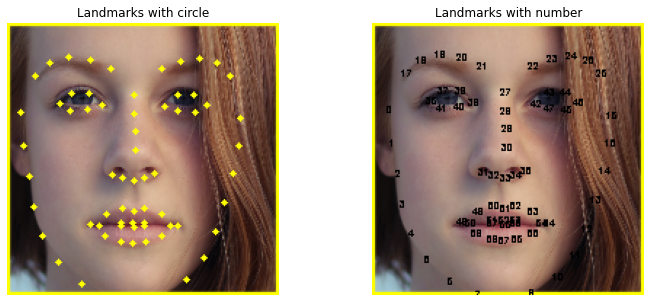

In [83]:
landmark_circle_image = img_rgb.copy()
landmark_number_image= img_rgb.copy()

# 이미지에 랜드마크 출력
for idx, point in enumerate(list_points):
    # 랜드마크 좌표에 원 표시
    cv2.circle(landmark_circle_image, point, 2, (255, 255, 0), -1) # cv2.circle(img, 중심좌표, 반지름, 색상, 선 두께, 선 종류)
    # 랜드마크 좌표에 인덱스 표시
    cv2.putText(landmark_number_image, text=str(idx), org=point, fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.2, color=(0,0,0)) # cv2.putText(img, text, 좌표, fontFace, fontScale, color, thickness)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(landmark_circle_image[top:top+height, left:left+width])
plt.title("Landmarks with circle")
plt.axis('off')                    

plt.subplot(1,2,2)
plt.imshow(landmark_number_image[top:top+height, left:left+width])
plt.title("Landmarks with number")
plt.axis('off')                    

plt.show()   

## 4. 스티커 사이즈 조정 및 적용 위치 확인

### 4.1 코끝의 위치와 face detection rectangle 활용
- 코끝 좌표를 스티커를 붙일 좌표의 기준점으로 활용한다.
- 위 과정에서 얻은 얼굴 탐지 범위의 가로크기를 스티커의 폭으로 조정한다.

In [84]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()

print ('(x,y) : (%d,%d)'%(x,y))  # 스티커의 위치 (x,y)
print ('(w,h) : (%d,%d)'%(w,h))  # 스티커의 크기 (w,h)

(x,y) : (330,226)
(w,h) : (187,187)


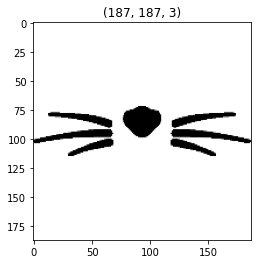

In [85]:
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 크기 resize
plt.title(img_sticker.shape)
plt.imshow(img_sticker)

In [86]:
# 이미지 시작점을 기준으로 좌표 조정(top-left 좌표)
img_sticker_x = x - w // 2  # left
img_sticker_y = y - h //2   # top
print ('(x,y) : (%d,%d)'%(img_sticker_x, img_sticker_y))

(x,y) : (237,133)


### 4.2 눈, 코 등 랜드마크 좌표를  이용
- 코끝 좌표를 스티커를 붙일 좌표의 기준점으로 활용한다.
- 양 눈의 끝 부분 좌표를 기준으로 스티커의 폭을 조정한다.

In [87]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = int((landmark[48][1] - landmark[36][1])* 1.4) # 눈 양끝 길이의 1.4배
    h = w
    print ('(x,y) : (%d,%d)'%(x,y))  # 스티커의 위치 (x,y)
    print ('(w,h) : (%d,%d)'%(w,h))  # 스티커의 크기 (w,h)

(x,y) : (330,226)
(w,h) : (116,116)


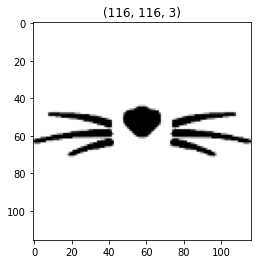

In [88]:
img_sticker2 = cv2.resize(img_sticker, (w,h)) # 스티커 크기 resize
plt.title(img_sticker2.shape)
plt.imshow(img_sticker2)

In [89]:
# 이미지 시작점을 기준으로 좌표 조정(top-left 좌표)
img_sticker2_x = x - w//2 # left
img_sticker2_y = y - h//2 # top
print ('(x,y) : (%d,%d)'%(img_sticker2_x, img_sticker2_y))

(x,y) : (272,168)


## 4. 스티커 적용하기

### 4.1 스티커 붙이기

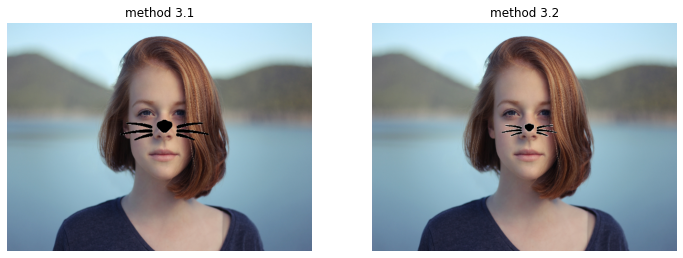

In [90]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
result_image = img_rgb.copy()
result_image2 = img_rgb.copy()

# 스티커 적용하기

# method 3.1
sticker_area = result_image[img_sticker_y:img_sticker_y + img_sticker.shape[0], 
                            img_sticker_x:img_sticker_x + img_sticker.shape[1]]

result_image[img_sticker_y:img_sticker_y + img_sticker.shape[0],
             img_sticker_x:img_sticker_x + img_sticker.shape[1]] = \
            np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8) # img_sticker가 0(하얀색)이면 img_sticker를 표시, 아니면 sticker_area

# method 3.2
sticker_area2 = result_image2[img_sticker2_y:img_sticker2_y + img_sticker2.shape[0], 
                            img_sticker2_x:img_sticker2_x + img_sticker2.shape[1]]

result_image2[img_sticker2_y:img_sticker2_y + img_sticker2.shape[0],
             img_sticker2_x:img_sticker2_x + img_sticker2.shape[1]] = \
            np.where(img_sticker2==255, sticker_area2, img_sticker2).astype(np.uint8) 



# 결과 이미지 출력
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("method 3.1")
plt.axis('off')
plt.imshow(result_image)

plt.subplot(1,2,2)
plt.title("method 3.2")
plt.axis('off')
plt.imshow(result_image2)

### 4.2 스티커 투명도 조절 (Image Blending)

이미지 블렌딩은 이미지를 서로 합칠 때 가중치를 두어 합치는 방법이다.
$g(x)=(1-a)f_0(x)+af_1(x)$
a의 값이 0에서 1로 변해감에 따라 $f_0(x)$(이미지1)효과는 작아지고 $f_1(x)$(이미지2)의 효과는 점점 커지게 된다.

이미지 블렌딩은 openCV의 addWeighted(img1,weight1,img2,weight2)를 사용한다.

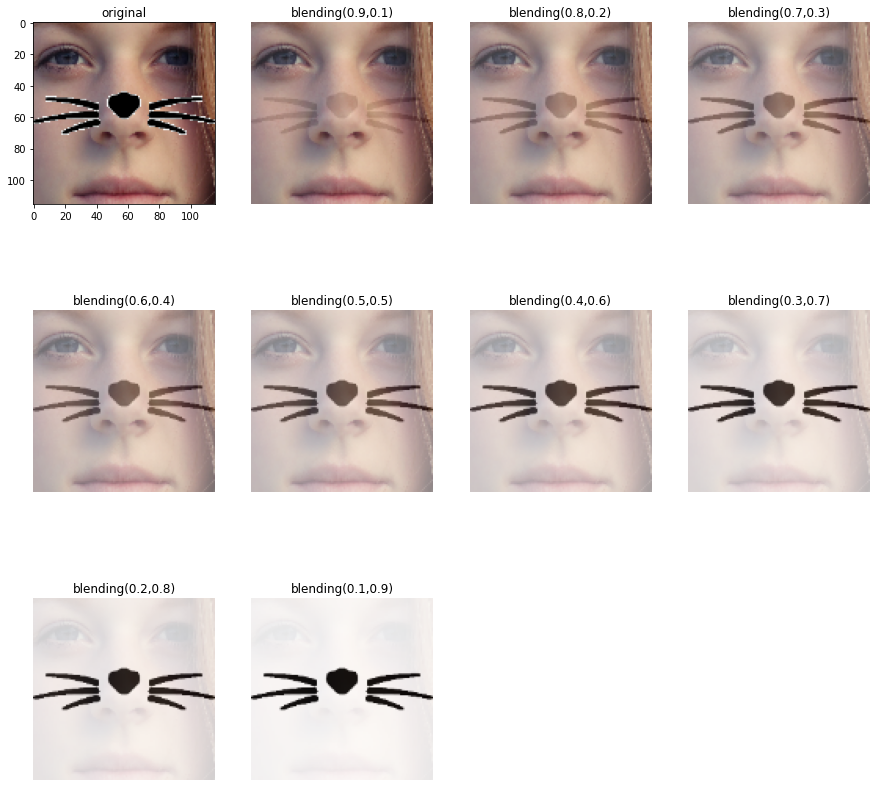

In [91]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
blending_image = img_rgb.copy()
blending_area = blending_image[img_sticker2_y:img_sticker2_y + img_sticker2.shape[0], 
                            img_sticker2_x:img_sticker2_x + img_sticker2.shape[1]]




plt.figure(figsize=(15,15))
for i in range(10):
    if i == 0:
        plt.subplot(3,4,i+1)
        plt.title("original")
        plt.imshow(sticker_area2)
    else:
        plt.subplot(3,4,i+1)
        plt.title("blending({:.1f},{:.1f})".format(1-i*0.1, i*0.1))
        transparent_sticker = cv2.addWeighted(blending_area, 1-i*0.1, img_sticker2, i*0.1, 0)
        plt.imshow(transparent_sticker)
        plt.axis('off')

plt.show()

## 5. 스티커 회전 시키기
- 랜드마크의 0번과 16번을 이용하여 얼굴의 기울기를 구한다.
- cv2.getRotationMatrix2D를 이용해 기운 각도 만큼 스티커를 회전한다. 
- 이미지에 회전한 스티커를 적용한다.

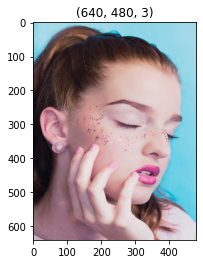

In [92]:
# 이미지 준비
img_path = os.getenv('HOME') + '/aiffel/camera_sticker/images/ian-dooley-kVJdgGPSUSI-unsplash.jpg'

img_bgr = cv2.imread(img_path, 1) # 이미지 파일 color로 읽기, 1 == cv2.IMREAD_COLOR
img_bgr = cv2.resize(img_bgr, (480, 640)) # 이미지 resize
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # RGB로 색상 변경


plt.imshow(img_rgb)
plt.title(img_rgb.shape)
plt.show()

rectangles[[(118, 162) (504, 547)]]


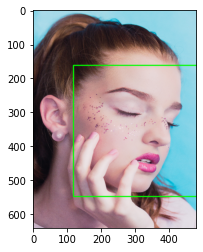

In [93]:
import dlib

detector_hog = dlib.get_frontal_face_detector() # face detector 불러오기
dlib_rects = detector_hog(img_rgb, 1) # detector_hog(image, upsample_num_times)

print(dlib_rects) # 얼굴영역의 좌표 출력

for rect in dlib_rects:
    left = rect.left()
    top = rect.top()
    right = rect.right()
    bottom = rect.bottom()
    width = rect.width()
    height = rect.height()

    cv2.rectangle(img_rgb, (left,top), (right,bottom), (0,255,0), 2, lineType=cv2.LINE_AA)
    # 사각형 그리기(img, 시작점 좌표, 종료점 좌표, 색상, 선 두꼐, 선 종류)

plt.imshow(img_rgb)
plt.show()

In [94]:
# land mark 모델 불러오기 (http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2)
model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [95]:
# 68개의 facelandmark 좌표 저장
list_landmarks = []
for dlib_rect in dlib_rects:
    
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) # 68개

68


랜드마크 인덱스를 저장하고, 그 중 양 볼이 시작되는 지점인 0번째, 16번째 인덱스를 가지고 기울기를 구할 것이다. 어떤 식으로 각도를 구할 수 있을지 직관적으로 보기 위해 두 점을 잇는 선을 빗변으로하는 직각 삼각형을 도식화 하였다.

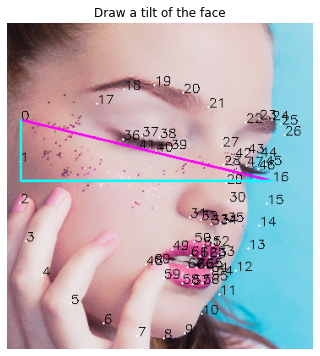

In [118]:
landmark_image = img_rgb.copy()

# 이미지에 랜드마크 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        # 랜드마크 좌표에 원 표시
        cv2.circle(landmark_image, point, 1, (255, 255, 255), -1) # cv2.circle(img, 중심좌표, 반지름, 색상, 선 두께, 선 종류)
        # 랜드마크 좌표에 인덱스 표시
        cv2.putText(landmark_image, text=str(idx), org=point, fontFace=cv2.FONT_ITALIC, fontScale=0.5, color=(0,0,0)) # cv2.putText(img, text, 좌표, fontFace, fontScale, color, thickness)
    # 얼굴의 기울기 시각화
    cv2.line(landmark_image, pt1=landmark[0], pt2=landmark[16], color=(255,0,255), thickness=2)
    cv2.line(landmark_image, pt1=landmark[0], pt2=(landmark[0][0], landmark[16][1]), color=(0,255,255), thickness=2)
    cv2.line(landmark_image, pt1=(landmark[0][0], landmark[16][1]), pt2=landmark[16], color=(0,255,255), thickness=2)
    
plt.figure(figsize=(6,6))
plt.imshow(landmark_image[top:top+height, left:left+width])
plt.title("Draw a tilt of the face")
plt.axis('off')                    
plt.show()

### 5.1 기울기 구하기

> arc tangent를 이용해 각도 $\theta$ 구하기 (이때,   $\theta$는 radian)
> - radian을 degree로 변경 → 1 radian = 180 / $\pi$

![Arc Tangent](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F162BA93350A4407D11)

In [119]:
import math

# 선분의 각도 구하기
def calculateAngle():
    # 오른쪽으로 기울어져 있는 경우
    if landmark[16][1] >=  landmark[0][1]:
        dx = landmark[16][0] - landmark[0][0]
        dy = -(landmark[16][1] - landmark[0][1])
        
    # 왼쪽으로 기울어져 있는 경우
    else:
        dx = landmark[16][0] - landmark[0][0]
        dy = landmark[0][1] - landmark[16][1]
    
    radian = math.atan(dy / dx)
    degree = radian/math.pi*180
    return degree

In [120]:
angle = calculateAngle()
print(angle)

-13.626994859891541


### 5.2 회전 시키기

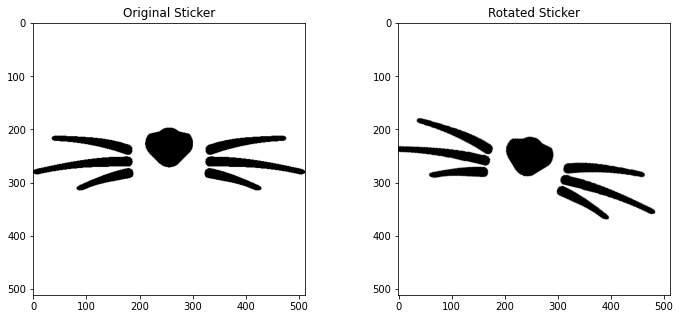

(512, 512, 3)


In [135]:
img_sticker3 = cv2.imread(sticker_path)
rotated_matrix = cv2.getRotationMatrix2D((landmark[33][0]//2, landmark[33][1]//2), angle, 1)
side_img_sticker = cv2.warpAffine(img_sticker3, rotated_matrix, (img_sticker3.shape[1], img_sticker3.shape[0]), borderValue=(255,255,255))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img_sticker3)
plt.title('Original Sticker')

plt.subplot(1,2,2)
plt.imshow(side_img_sticker)
plt.title('Rotated Sticker')

plt.show()
print(img_sticker3.shape)

In [136]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = int((landmark[48][1] - landmark[36][1])* 1.3) # 눈 양끝 길이의 1.3배
    h = w

img_sticker3 = cv2.resize(img_sticker, (w,h)) # 스티커 크기 resize
side_img_sticker = cv2.resize(side_img_sticker, (w,h))
print(img_sticker3.shape)

# 이미지 시작점을 기준으로 좌표 조정(top-left 좌표)
img_sticker3_x = x - w // 2  # left
img_sticker3_y = y - h //2   # top

(192, 192, 3)


### 5.3 회전된 스티커 적용

In [137]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
original_img = img_rgb.copy()
rotated_img = img_rgb.copy()

# 기본 수염 장착
sticker_area3 = original_img[img_sticker3_y:img_sticker3_y + img_sticker3.shape[1], 
                            img_sticker3_x:img_sticker3_x + img_sticker3.shape[0]]

original_img[img_sticker3_y:img_sticker3_y + img_sticker3.shape[1],
             img_sticker3_x:img_sticker3_x + img_sticker3.shape[0]] = \
            np.where(img_sticker3==255, sticker_area3, img_sticker3).astype(np.uint8) 

In [138]:
# 회전된 수염 장착
sticker_area4 = rotated_img[img_sticker3_y:img_sticker3_y + img_sticker3.shape[1], 
                            img_sticker3_x:img_sticker3_x + img_sticker3.shape[0]]

rotated_img[img_sticker3_y:img_sticker3_y + img_sticker3.shape[1],
             img_sticker3_x:img_sticker3_x + img_sticker3.shape[0]] = \
            np.where(side_img_sticker==255, sticker_area4, side_img_sticker).astype(np.uint8) 


print(img_sticker3.shape)
print(sticker_area3.shape)

(192, 192, 3)
(192, 192, 3)


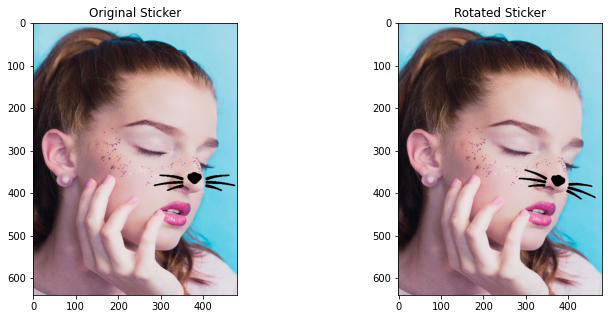

In [139]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(original_img)
plt.title('Original Sticker')

plt.subplot(1,2,2)
plt.imshow(rotated_img)
plt.title('Rotated Sticker')

plt.show()

## 6. 여러 사진에 테스트 해보기

다양한 사진에 적용해 보기 위해 스티커를 붙이는 과정을 함수로 만들어 적용하였다.

In [52]:
def attach_cat_whiskersr(img_name):
    try:
        # 사진 준비하기
        img_path = img_path = os.getenv('HOME') + f'/aiffel/camera_sticker/images/{img_name}'
        img_bgr = cv2.imread(img_path, 1) # 이미지 파일 color로 읽기, 1 == cv2.IMREAD_COLOR

        img_bgr = cv2.resize(img_bgr, dsize=(0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR) # 이미지 resize
        img_show = img_bgr.copy() # 출력용 이미지 별도 보관
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # RGB로 색상 변경

        detector_hog = dlib.get_frontal_face_detector()
        dlib_rects = detector_hog(img_rgb, 1) # (image, upsample_num_times)

        # landmark 모델 불러오기
        model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
        landmark_predictor = dlib.shape_predictor(model_path)

        # 68개의 facelandmark 좌표 저장
        list_landmarks = []
        for dlib_rect in dlib_rects:
            points = landmark_predictor(img_rgb, dlib_rect)
            list_points = list(map(lambda p: (p.x, p.y), points.parts()))
            list_landmarks.append(list_points)

        # 스티커 불러와서 resize 
        sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
        img_sticker = cv2.imread(sticker_path)

        for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
            x = landmark[30][0]
            y = landmark[30][1]
            w = int((landmark[48][1] - landmark[36][1])* 1.4) # 눈 양끝 길이의 1.4배
            h = w

        img_sticker = cv2.resize(img_sticker, (w,h))# 스티커 크기 resize


        # 스티커 붙일 좌표 설정
        refined_x = x - w // 2  # left
        refined_y = y - h //2   # top


        # 원본 이미지에 스티커 적용하기
        sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
        img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8) # img_sticker가 0이면 img_sticker를 사용, 아니면 sticker_area 

        # 결과 이미지 출력
        attached_sticker = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(attached_sticker)
        plt.show()
    except (UnboundLocalError): # 에러나면 사진 출력
        img_path = img_path = os.getenv('HOME') + f'/aiffel/camera_sticker/images/{img_name}'
        img_bgr = cv2.imread(img_path, 1) # 이미지 파일 color로 읽기, 1 == cv2.IMREAD_COLOR
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # RGB로 색상 변경
        plt.imshow(img_rgb)
        print("undeteced photo🤪")
        return plt.show()
    
    return attached_sticker

***

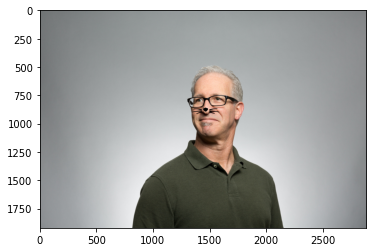

In [53]:
img_name = 'foto-sushi-6anudmpILw4-unsplash.jpg'
attached_sticker_img = attach_cat_whiskersr(img_name)

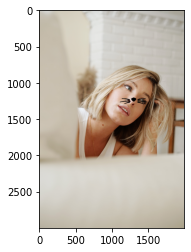

In [54]:
img_name = 'mathilde-langevin-xAydG6f9yoc-unsplash.jpg'
attached_sticker_img = attach_cat_whiskersr(img_name)

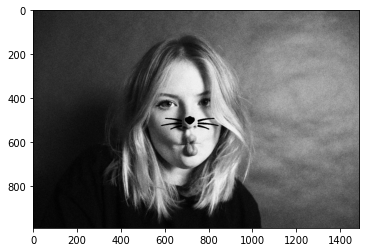

In [55]:
img_name = 'maria-lysenko-mjaMxrxNMHY-unsplash.jpg'
attached_sticker_img = attach_cat_whiskersr(img_name)

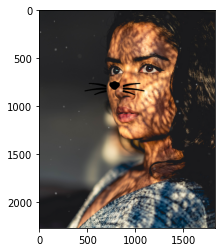

In [56]:
img_name = 'justin-merced-3pjAdQzl_y8-unsplash.jpg'
attached_sticker_img = attach_cat_whiskersr(img_name)

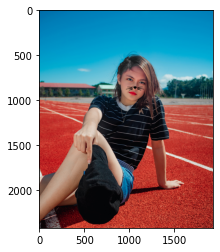

In [57]:
img_name = 'karl-joshua-bernal-1m8dYjmAU7M-unsplash.jpg'
attached_sticker_img = attach_cat_whiskersr(img_name)

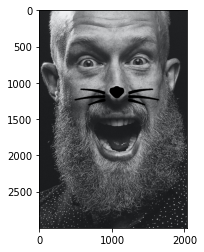

In [58]:
img_name = 'alexander-krivitskiy-TD9rSZywT7Y-unsplash.jpg'
attached_sticker_img = attach_cat_whiskersr(img_name)

undeteced photo🤪


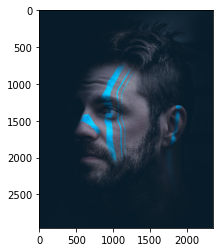

In [59]:
img_name = 'daniel-lincoln-NR705beN_CU-unsplash.jpg'
attached_sticker_img = attach_cat_whiskersr(img_name)

undeteced photo🤪


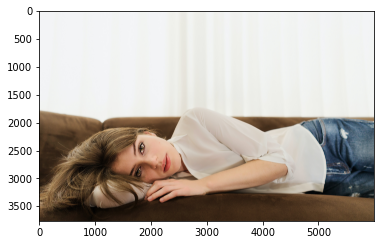

In [60]:
img_name = 'rodolfo-marques-3VztPWkNi4k-unsplash.jpg'
attached_sticker_img = attach_cat_whiskersr(img_name)

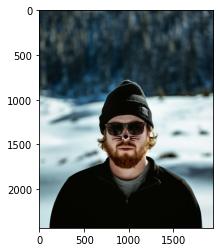

In [61]:
img_name = 'jake-fagan-Y7C7F26fzZM-unsplash.jpg'
attached_sticker_img = attach_cat_whiskersr(img_name)

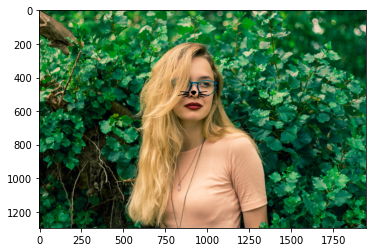

In [62]:
img_name = 'max-ilienerwise-YvWJOXHNJ94-unsplash.jpg'
attached_sticker_img = attach_cat_whiskersr(img_name)

undeteced photo🤪


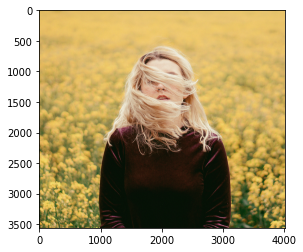

In [63]:
img_name = 'michal-binkiewicz-FzhHEEOkPEI-unsplash.jpg'
attached_sticker_img = attach_cat_whiskersr(img_name)

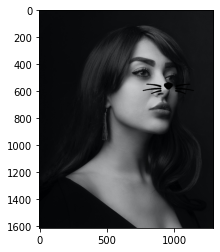

In [64]:
img_name = 'mohammad-khaksarmadani-4FDsNcCR8iQ-unsplash.jpg'
attached_sticker_img = attach_cat_whiskersr(img_name)

***


## 프로젝트 정리

### 1. 이미지 준비하기(스티커, 사진)
- resize 시에는 원본 이미지의 비율을 그대로 가져가는게 좋은 것 같다.
- 세로가 긴 이미지를 가로가 긴 이미지로 resize 했을 때 face detection이 안된다..( 얼굴의 비율때문에 HOG 패턴과 유사성이 떨어져서 생기는 문제인것 같다.🙄)


### 2. Face Detection
- dlib의 get_frontal_face_detector()를 이용해 얼굴영역을 찾아낸다.
- 얼굴영역에서 찾아낸 좌표를 가지고 범위를 bounding box로 표시하였다.
- cv2는 색상표를 bgr로 가지기 때문에 cv2.circle(), cv2.rectangle() 등을 이용해 도형을 그릴때 색상도 b,g,r 순서로 지정해줘야한다.


### 3. Landmark Detection
- dlib의 pretrained model을 이용해 랜드마크를 찾아냈다.
-  스티커의 위치나 얼굴의 기울기 등을 랜드마크 좌표를 이용해 조정해 주기때문에 편의를 위해 cv2.putText()를 이용하여 좌표의 인덱스를 표시하였다.

### 4. 스티커 사이즈 조정 및 적용 위치 확인
- 스티커를 얼굴에 적당한 크기로 붙여주기 위해 코끝(30번째 랜드마크)좌표와 bounding box 범위를 이용했다.
- 스티커의 가로, 세로 비율도 1:1이고 얼굴범위인 bounding box도 1:1로 되어 있어 위치만 맞추면 자연스럽게 수염 스티커 적용을 할 수 있었다.
- 그런데 스티커를 얼굴크기와 1:1비율로 하다보니 너무 커보여서 고양이 수염🐱인지 호랑이 수염🐯인지..모르겠어 비율조정을 해보았다. 
- 양 눈끝 길이를 기준으로 1.3~1.5배 정도로 조정하고 붙여보니 적당해 보여 최종적으로 1.4배로 하였다.
- 스티커를 자연스럽게 보이게하기위해 이미지와 블렌딩 시켜봤는데 아무리 시도해봐도 배경이미지만 옅어지고 수염이미지의 명도는 변함이 없어서 거의 포기 할뻔했다..
- 위 현상은 이미지를 copy해서 사용하며 나타난 문제로 이미지를 초기화 시켜주니 잘 적용되었다.(스티커가 중첩되거나 할때도 유용하게 사용한 방법)

### 5. 스티커 회전 시키기
- 아지트에서 @전지은님이 공유해주신 방법을 참고하여 수염 이미지를 회전 시켜보았다.
- 양 볼의 시작점인 0번과 16번을 기준으로 삼아 두 점을 잇는 직선의 기울기를 구하여 radian을 구하고 degree로 변환하는 함수를 만들어 사용하였다.
- 오른쪽으로 기운 얼굴은 음의 각도를 반환하고, 왼쪽으로 기운 얼굴은 양의 각도를 반환한다.
- cv2.getRotationMatrix2D()를 이용해 이미지를 회전시켜주었다. 양의 각도는 시계반대방향으로 회전한다.
- 구한 각도대로 수염을 회전시키면 코 끝보다 살짝 위인 콧등쪽에 스티커가 붙어 중심좌표를 2로 나눈 몫으로 위치를 조정해주었다.
- cv2.warpAffine()를 이용해 이미지의 위치를  변경해주었다.


### 6. 여러 사진에 테스트 해보기

- 얼굴 인식 가능
    - (얼굴이 구분 될 만큼) 멀리서 찍은 사진
    - 60도 정도 기울어 있는 사진
    - 입을 오므리거나 크게 벌려 이목구비가 변형된 사진
    - 복잡한 패턴의 그림자가 얼굴에 덧씌워져 있는 사진
    - 선글라스😎
    - (머리카락 등으로) 얼굴의 일부만 가려진 사진

- 얼굴 인식 불가
    - 얼굴이 90도정도 회전되어 있는 사진
    - 얼굴형이 가려진 사진(눈 한쪽 정도는 가능)
    - (그림자로 인해) 얼굴형과 이목구비 인식이 어려운 사진


### 7. 프로젝트 발전시키기?
- 고양이 귀도 같이 달아주는 스티커 앱
- 입력받은 사진 대로 스티커 회전 및 원근감 표현해주기
- 사진에 여러 사람들이 있을 때 각 얼굴마다 스티커 추가해주기
- 스티커 색을 원하는 색으로 변경